In [4]:
import numpy as np
import sympy
from sympy import Expr, Eq, latex, plot_implicit, tan, cot
from sympy.core import S, pi, sympify
from sympy.core.logic import fuzzy_bool
from sympy.core.numbers import Rational, oo
from sympy.core.compatibility import ordered
from sympy.core.symbol import Dummy, _uniquely_named_symbol, _symbol
from sympy.simplify import simplify, trigsimp
from sympy.functions.elementary.miscellaneous import sqrt, Max
from sympy.functions.elementary.trigonometric import cos, sin
from sympy.functions.special.elliptic_integrals import elliptic_e
from sympy.geometry.exceptions import GeometryError
from sympy.geometry.line import Ray2D, Segment2D, Line2D, LinearEntity3D
from sympy.polys import DomainError, Poly, PolynomialError
from sympy.polys.polyutils import _not_a_coeff, _nsort
from sympy.solvers import solve
from sympy.solvers.solveset import linear_coeffs
from sympy.utilities.misc import filldedent, func_name
from sympy.geometry.entity import GeometryEntity, GeometrySet
from sympy.geometry.point import Point, Point2D, Point3D
from sympy.geometry.line import Line, Segment
from sympy.geometry.util import idiff
import matplotlib.pyplot as plt
%matplotlib inline

# Занятие 15
# Алгебра
## Кривые второго порядка на плоскости: гипербола

In [5]:
class Hyperbola(GeometrySet):
    """
     Attributes
    ==========
    center
    hradius
    vradius
    eccentricity
    periapsis
    focus_distance
    foci
    ==========
    конструктор __new__
    скопирован из Эллипса,
    изменена формула для  hradius и vradius через эсцентриситет
    """
    def __new__(
        cls, center=None, hradius=None, vradius=None, eccentricity=None, **kwargs):
        hradius = sympify(hradius)
        vradius = sympify(vradius)

        eccentricity = sympify(eccentricity)

        if center is None:
            center = Point(0, 0)
        else:
            center = Point(center, dim=2)

        if len(center) != 2:
            raise ValueError('The center of "{0}" must be a two dimensional point'.format(cls))

        if len(list(filter(lambda x: x is not None, (hradius, vradius, eccentricity)))) != 2:
            raise ValueError(filldedent('''
                Exactly two arguments of "hradius", "vradius", and
                "eccentricity" must not be None.'''))

        if eccentricity is not None:
            if hradius is None:
                hradius = vradius/sqrt( eccentricity**2 - 1)
            elif vradius is None:
                vradius = hradius*sqrt( eccentricity**2 - 1)

        if hradius == 0:
            return "Line"
        if vradius == 0:
            return "Rays"
        return GeometryEntity.__new__(cls, center, hradius, vradius, **kwargs)
    
    @property
    def ambient_dimension(self):
        return 2
    
    @property
    def center(self):
        return self.args[0]

    @property
    def hradius(self):
        return self.args[1]
    
    @property
    def vradius(self):
        return self.args[2]
    @property
    def focus_distance(self):
        return sqrt(self.hradius**2 + self.vradius**2)
    
    @property
    def eccentricity(self):
        """The eccentricity of the ellipse."""
        return self.focus_distance/self.hradius
    
    @property
    def periapsis(self):
        """The apoapsis of the hyperbola.
        The smallest distance between the focus and the contour."""
        return self.focus_distance-self.hradius
    @property
    def foci(self):
        return (self.center + Point(-self.focus_distance, 0), self.center + Point(self.focus_distance, 0))
    
    @property
    def major(self):
        return self.hradius
    
    @property
    def minor(self):
        return self.vradius
    
    def equation(self, x='x', y='y', _slope=None, equation=False):
        """
        Returns the equation of a hyperbola aligned with the x and y axes;
        when slope is given, the equation returned corresponds to a hyperbola 
        with a major axis having that slope.
        Parameters
        ==========
        x : str, optional
            Label for the x-axis. Default value is 'x'.
        y : str, optional
            Label for the y-axis. Default value is 'y'.
        _slope : Expr, optional
                The slope of the major axis. Ignored when 'None'.
        Returns
        =======
        equation : sympy expression   """

        x = _symbol(x, real=True)
        y = _symbol(y, real=True)

        dx = x - self.center.x
        dy = y - self.center.y

        if _slope is not None:
            L = (dy - _slope*dx)**2
            l = (_slope*dy + dx)**2
            h = 1 + _slope**2
            a = h*self.major**2
            b = h*self.minor**2
            res= l/a - L/b 

        else:
            t1 = (dx/self.hradius)**2
            t2 = (dy/self.vradius)**2
            res = t1 - t2 
            
        if not equation:
            return res - 1
        else:
            return Eq(res, 1)
        
    def asymptote(self, x='x', y='y', equation=False):
        x = _symbol(x, real=True)
        y = _symbol(y, real=True)
        if not equation:
                return (y - self.center.y - (self.vradius / self.hradius) * (x - self.center.x),
                        y - self.center.y + (self.vradius / self.hradius) * (x - self.center.x))
        else:
                return (Eq(y, self.center.y + (self.vradius / self.hradius) * (x - self.center.x)),
                        Eq(y, self.center.y - (self.vradius / self.hradius) * (x - self.center.x)))
            
    def directrix(self, x='x', equation=False):
        x = _symbol(x, real=True)
        if not equation:
            return (x - self.center.x - (self.hradius ** 2) / self.focus_distance,
                    x - self.center.x + (self.hradius ** 2) / self.focus_distance)
        else:
            return (Eq(x, self.center.x + (self.hradius ** 2) / self.focus_distance,),
                    Eq(x, self.center.x - (self.hradius ** 2) / self.focus_distance))

# Занятие 15
# Алгебра
### Задание 1.
Построить гиперболу с центром в точке А(1, 2), полуосями 12 и 5. Вывести на экран эксцентриситет, фокусное расстояние, фокусы (с координатами), periapsis и уравнение гиперболы.

In [6]:
Hyp1 = Hyperbola(Point(1,2), hradius=12, vradius=5)
display(Hyp1)
props = {'eccentricity': Hyp1.eccentricity, 'periapsis': Hyp1.periapsis,
         'focus_distance': Hyp1.focus_distance, 'foci': Hyp1.foci, 'equation':Hyp1.equation(equation=True)}
for key in props.keys():
    display(key, props[key])

Hyperbola(Point2D(1, 2), 12, 5)

'eccentricity'

13/12

'periapsis'

1

'focus_distance'

13

'foci'

(Point2D(-12, 2), Point2D(14, 2))

'equation'

Eq((x/12 - 1/12)**2 - (y/5 - 2/5)**2, 1)

### Задание 2.
Добавить в описание класса гипербол методы 

asymptote(self, x='x', y='y', equation=False)

directrix(self, x='x', equation=False)

Для гиперболы Задания 1 вывести на экран уравнения асимптот и директрис.

In [7]:
display(*Hyp1.asymptote(equation=True))
display(*Hyp1.directrix(equation=True))

Eq(y, 5*x/12 + 19/12)

Eq(y, 29/12 - 5*x/12)

Eq(x, 157/13)

Eq(x, -131/13)

### Задание 3.
Вывести на экран уравнение гиперболы из задания 1 с поворотом на 30 градусов против часовой стрелки относительно ее центра.
Изобразить повернутую гиперболу с помощью plot_implicit.

Eq((3*x + sqrt(3)*(y - 2) - 3)**2/1728 - (-3*y + sqrt(3)*(x - 1) + 6)**2/300, 1)

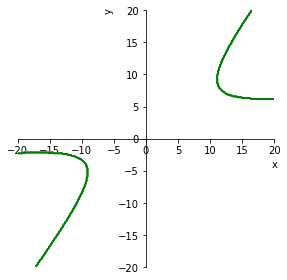

In [8]:
display(Hyp1.equation(_slope=(3**(S(1)/2)/3), equation=True).simplify())
eq1 = Hyp1.equation(x='x', y='y')
dict_free = {str(a): a for a in eq1.free_symbols}
p = plot_implicit(Hyp1.equation(x='x', y='y', _slope=3**(S(1)/2)/3), (dict_free['x'], -20, 20), (dict_free['y'], -20, 20),
                  line_color='g', aspect_ratio=(1, 1), show=False, adaptive=False)
p.show()

## Уравнения директрис и асимптот при повороте на угол $\alpha$
Пусть  $a$ - горизонтальная полуось, $c$ - фокусное расстояние, $x_0$ - горизонтальная координата центра гиперболы, тогда уравнение директрис 
$$
x = x_0 \pm \frac{a^2}{c}
$$
При повороте на угол $\alpha$ получается уравнение
$$
y = y_0 -{\rm ctg} \alpha(x - x_0) \pm \frac{a^2}{c}\sqrt{1 + {\rm ctg} \alpha}
$$
Уравнение асимптоты
$$
y = y_0 \pm \frac{b}{a}(x - x_0)
$$
При повороте на угол $\alpha$ получаются уравнения
\begin{align*}
y_1 = y_0 + k_1(x - x_0), \quad 
y_2 = y_0 + k_2(x - x_0), \\ 
k_1 = \frac{b + a{\rm tg} \alpha}{a - b{\rm tg} \alpha},\quad 
k_2 = \frac{-b + a{\rm tg} \alpha}{a + b{\rm tg} \alpha}
\end{align*}
### Задание 4.
Изобразить гиперболу Задания 3 (т.е. повернутую на угол) и ее асимптоты и директрисы на одном графике plot_implicit.

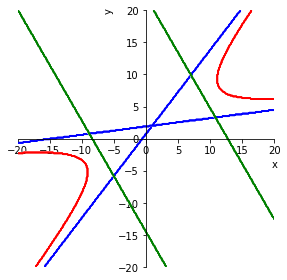

In [9]:
a = Hyp1.hradius
b = Hyp1.vradius
c = Hyp1.focus_distance
x = dict_free['x']
y = dict_free['y']
eq1 = Hyp1.equation(_slope=(3**(S(1)/2)/3), equation=True).simplify()
x0 = Hyp1.center.x
y0 = Hyp1.center.y
alpha = 30 * sympy.pi/180
k1 = (b + a * tan(alpha)) / (a - b * tan(alpha))
k2 = (-b + a * tan(alpha)) / (a + b * tan(alpha))
p = plot_implicit(Hyp1.equation(x='x', y='y', _slope=3**(S(1)/2)/3), (dict_free['x'], -20, 20), (dict_free['y'], -20, 20),
                  line_color='r', aspect_ratio=(1, 1), show=False, adaptive=False)
p.extend(plot_implicit(Eq(y, y0 + k1 * (x - x0)), (dict_free['x'], -20, 20), (dict_free['y'], -20, 20),
                  line_color='b', aspect_ratio=(1, 1), show=False, adaptive=False))
p.extend(plot_implicit(Eq(y, y0 + k2 * (x - x0)), (dict_free['x'], -20, 20), (dict_free['y'], -20, 20),
                  line_color='b', aspect_ratio=(1, 1), show=False, adaptive=False))
p.extend(plot_implicit(Eq(y, y0 - cot(alpha) * (x - x0) + (a**2 / c) * (1 + cot(alpha))**(1/2)), (dict_free['x'], -20, 20), (dict_free['y'], -20, 20),
                  line_color='g', aspect_ratio=(1, 1), show=False, adaptive=False))
p.extend(plot_implicit(Eq(y, y0 - cot(alpha) * (x - x0) - (a**2 / c) * (1 + cot(alpha))**(1/2)), (dict_free['x'], -20, 20), (dict_free['y'], -20, 20),
                  line_color='g', aspect_ratio=(1, 1), show=False, adaptive=False))
p.show()

###  Индивидуальное задание
Определить гиперболу с центром в точке $O$, полуосями $a$ и $b$.  Вывести на экран эксцентриситет, фокусное расстояние, фокусы (с координатами), periapsis, уравнение гиперболы, уравнения асимптот и директрис. 

Изобразить гиперболу, повернутую на $\alpha$ градусов против часовой стрелки относительно ее центра, соответствующие асимптоты и директрисы. Вывести на экран уравнения повернутой гиперболы, соответствующих асимптот и директрис.

'eccentricity'

5/4

'periapsis'

2

'focus_distance'

10

'foci'

(Point2D(-5, 5), Point2D(15, 5))

'equation'

Eq((x/8 - 5/8)**2 - (y/6 - 5/6)**2, 1)

asymptotes


Eq(y, 3*x/4 + 5/4)

Eq(y, 35/4 - 3*x/4)

directices


Eq(x, 57/5)

Eq(x, -7/5)

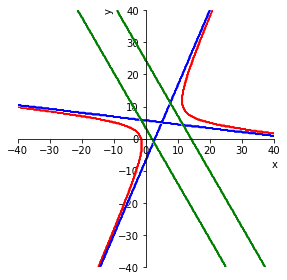

In [12]:
Hyp2 = Hyperbola(Point2D(5, 5), 8, 6)
c = Hyp2.focus_distance
eq2 = Hyp2.equation(_slope=(3**(S(1)/2)/3), equation=True).simplify()
x0 = Hyp2.center.x
y0 = Hyp2.center.y
dict_free = {str(a): a for a in eq2.free_symbols}
x = dict_free['x']
y = dict_free['y']
a = Hyp2.hradius
b = Hyp2.vradius
alpha = sympy.pi / 6
props = {'eccentricity': Hyp2.eccentricity, 'periapsis': Hyp2.periapsis,
         'focus_distance': Hyp2.focus_distance, 'foci': Hyp2.foci, 'equation':Hyp2.equation(equation=True)}
for key in props.keys():
    display(key, props[key])
print('asymptotes')
display(*Hyp2.asymptote(equation=True))
print('directices')
display(*Hyp2.directrix(equation=True))

k1 = (b + a * tan(alpha)) / (a - b * tan(alpha))
k2 = (-b + a * tan(alpha)) / (a + b * tan(alpha))
p = plot_implicit(Hyp2.equation(x='x', y='y', _slope=3**(S(1)/2)/3), (dict_free['x'], -40, 40), (dict_free['y'], -40, 40),
                  line_color='r', aspect_ratio=(1, 1), show=False, adaptive=False)
p.extend(plot_implicit(Eq(y, y0 + k1 * (x - x0)), (dict_free['x'], -40, 40), (dict_free['y'], -40, 40),
                  line_color='b', aspect_ratio=(1, 1), show=False, adaptive=False))
p.extend(plot_implicit(Eq(y, y0 + k2 * (x - x0)), (dict_free['x'], -40, 40), (dict_free['y'], -40, 40),
                  line_color='b', aspect_ratio=(1, 1), show=False, adaptive=False))
p.extend(plot_implicit(Eq(y, y0 - cot(alpha) * (x - x0) + (a**2 / c) * (1 + cot(alpha))**(1/2)), (dict_free['x'], -40, 40), (dict_free['y'], -40, 40),
                  line_color='g', aspect_ratio=(1, 1), show=False, adaptive=False))
p.extend(plot_implicit(Eq(y, y0 - cot(alpha) * (x - x0) - (a**2 / c) * (1 + cot(alpha))**(1/2)), (dict_free['x'], -40, 40), (dict_free['y'], -40, 40),
                  line_color='g', aspect_ratio=(1, 1), show=False, adaptive=False))
p.show()